# Radar proccessing

In [1]:
%matplotlib inline
import numpy as np

## Creation of the signal

In [2]:
from blocksim.dsp.DSPSignal import DSPSignal

# Reference chirp generation
tau = 10e-6  # Duration of one pulse
bp = 5e6  # Bandwidth
fs = bp * 3  # Sampling frequency
eta = 0.1  # Duty cycle of repetitions
nrep = 50  # Number of repetitions
fdop = 1e3  # Doppler frequency
wl = 0.2  # wavelength

rep = DSPSignal.fromLinearFM(
    name="rep",
    samplingStart=0,
    samplingPeriod=1 / fs,
    tau=tau,
    fstart=-bp / 2,
    fend=bp / 2,
)

# Noisy received signal with nrep repetitions
ns_rep = len(rep)

ns = int(ns_rep / eta)
tps = np.arange(nrep * ns) / fs
y_sig = np.zeros(nrep * ns, dtype=np.complex128)
for k in range(nrep):
    y_sig[k * ns : k * ns + ns_rep] = rep.y_serie * k
sig = (
    DSPSignal.fromTimeAndSamples(name="sig", tps=tps, y_serie=y_sig)
    .applyDopplerFrequency(fdop=fdop)
    .applyGaussianNoise(pwr=5)
    .applyDelay(10e-6)
)

[09/21/22 13:05:41] INFO     Registered blocksim.loggers.CSVLogger                                  ]8;id=330161;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py\__init__.py]8;;\:]8;id=593533;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py#123\123]8;;\

                    INFO     Registered blocksim.loggers.ParquetLogger                              ]8;id=892890;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py\__init__.py]8;;\:]8;id=307106;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py#123\123]8;;\

                    INFO     Registered blocksim.loggers.PickleLogger                               ]8;id=301632;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py\__init__.py]8;;\:]8;id=827334;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py#123\123]8;;\

                    INFO     Registered blocksim.loggers.XlsLogger                                  ]8;id=965071;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py\__init__.py]8;;\:]8;id=107808;file:///home/yannbdt/repos/blocksim/blocksim/__init__.py#123\123]8;;\

## Processing

Peak(Doppler=999 Hz, Delay=10 µs, value=27.8)


[09/21/22 13:05:47] INFO     Found peak : Peak(Doppler=999 Hz, Delay=10 µs, value=27.8)            ]8;id=161417;file:///home/yannbdt/repos/blocksim/blocksim/graphics/Plottable.py\Plottable.py]8;;\:]8;id=221393;file:///home/yannbdt/repos/blocksim/blocksim/graphics/Plottable.py#738\738]8;;\

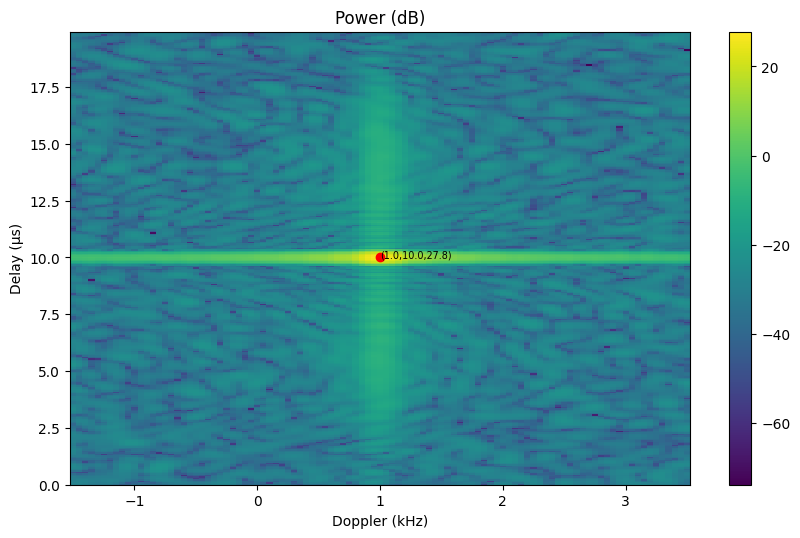

In [3]:
# Definitions
from blocksim.constants import c

Tr = tau / eta  # Repetition period
Tana = nrep * Tr  # Analysis duration
Rf = 1 / Tana  # Frequency resolution
Rv = Rf * wl  # Velocity resolution
Rd = c / bp * 1.4  # Distance resolution
doppler_search_win = 1 / 2 / Tr  # Size of analyse window in the velocity axis
delay_search_win = 2 * tau  # Size of analyse window in the distance axis

# Analysis of the received signal
from blocksim.dsp import delay_doppler_analysis

spg = delay_doppler_analysis(
    period=Tr,
    delay_search_center=tau,
    delay_search_win=delay_search_win,
    doppler_search_center=fdop,
    doppler_search_win=doppler_search_win,
    seq=rep,
    rxsig=sig,
    ndop=100,
    corr_window="hamming",
    progress_bar=False,
)

trf = DSPSignal.to_db_lim(-80)
(peak,) = spg.findPeaksWithTransform(transform=trf, nb_peaks=1)
print(peak)

# Plotting
from blocksim.graphics.BFigure import FigureFactory

fig = FigureFactory.create()
gs = fig.add_gridspec(1, 1)
axe = fig.add_baxe(title="Power (dB)", spec=gs[0, 0])
axe.plot(
    spg,
    transform=trf,
    find_peaks=1,
)
mfig = fig.render()